<a href="https://colab.research.google.com/github/pathwaycom/pathway/blob/main/examples/notebooks/tutorials/upsampling.ipynb" target="_parent"><img src="https://pathway.com/assets/colab-badge.svg" alt="Run In Colab" class="inline"/></a>

# Installing Pathway with Python 3.10+

In the cell below, we install Pathway into a Python 3.10+ Linux runtime.

> **If you are running in Google Colab, please run the colab notebook (Ctrl+F9)**, disregarding the 'not authored by Google' warning.
> 
> **The installation and loading time is less than 1 minute**.


In [ ]:
%%capture --no-display
!pip install --prefer-binary pathway

In [ ]:
import logging

logging.basicConfig(level=logging.CRITICAL)

# Signal Processing with Real-time Upsampling: combining multiple time series data streams..
Learn how to perform upsampling on multiple data streams. The data streams will be modelled as time series data and will have different sampling rates to begin with.
Using upsampling techniques in Python, you will align the sampling rates of the multiple data sources in order to perform data analysis over the entire stream.

It is common practice to use [Digital Signal Processing](/glossary/digital-signal-processing) (DSP) in order to analyze and manipulate time series data.
The time series can be considered as signals and by applying filters, you can remove the noise and do feature extraction on your data.
However, when working with multiple time series you are likely to run into the issue of data misalignment due to different sampling rates.
This issue needs to be addressed if you want to extract valuable insights from your time series data using digital signal processing.
In this article, you will learn how to use upsampling to align the sampling rates of your multiple time series data sources.

## Upsampling: Working with Messy Real-World Data
This tutorial builds on the [Gaussian Filtering](/developers/templates/gaussian_filtering_python) tutorial which explains how you can smooth out a messy, out-of-order data stream.
While digital signal processing systems assume neatly ordered signals arriving at a regular and precise sampling rate, this is rarely the case in [real-world applications](/blog/iot-data-analytics/).
Irregular and out-of-order data streams are a common occurrence in the real world of data processing.
Data streams may be sampled at irregular intervals, leading to variations in the time between samples. The resulting data is noisy and contains gaps.

This upsampling tutorial adds another layer of complexity: you will learn how work with *multiple* data sources simultaneously.
This is an important skill to master because analyzing multiple data sources together is a common method to improve the quality of an analysis.
For example, you can improve the accuracy of any metric by averaging the measures of different sensors measuring it.

In addition to the noisy, late, and out-of-order data points, you will now face a new challenge: **data streams have different sampling rates.**
This will result in significant data misalignment which you will have to deal with in order to extract meaningful information from your data.
This challenge requires a different approach to data processing compared to idealized signal processing, where the focus is on precise time alignment.
In particular, to align two data sources with different sampling rate, you will need to do something called **upsampling**.

# What is Upsampling?

[Upsampling](/glossary/upsampling) is a [signal processing](/glossary/signal-processing) technique used to increase the sampling rate of a signal.
Upsampling is generally used to improve a signal and applications include improving the quality of images, increasing the accuracy of digital filters, or data enrichment.

## Upsampling: Combining Data Streams with Different Sampling Rates

In many real-world scenarios, you may need to process data from multiple sources, each with its own sampling rate.
To work on both signals at the same time, it's important to have the same sampling rate in both signals. This can be done with [resampling](/glossary/resampling).
Resampling is the process of changing the sampling rate or the number of samples in a signal or data set. There are two primary types of resampling:
 1. **Upsampling** consists of increasing the sampling rate by adding new data points between existing ones to achieve a higher temporal or spatial resolution. It is used to increase the clarity of a signal or match the sampling rate of one signal to that of another for compatibility. New values are obtained by doing an **interpolation**.
 2. **[Downsampling](/glossary/downsampling)**, on the other hand, consists of decreasing the sampling rates by removing data points. It is typically used to reduce data volume, decrease computational complexity, and meet application storage or transmission constraints.

For example, consider a simple scenario: you are training to run your first marathon.
You would like to monitor your performance, so you buy a GPS watch.
After your first run, you read out the data and notice that sometimes the measurements of the watch are not very precise.
Fortunately, you have another source of GPS data points: your phone!
You plan to join the two streams to increase their accuracy.

Unfortunately, the time series are very different.
While your phone outputs roughly one value per second, your GPS watch has only one recording every five seconds.
You will need to upsample your watch's data to match the sampling rate of your phone.

Don't worry, Pathway allows you to aggregate and process data from these diverse sources easily.
Let's see how to do upsampling with Pathway.

### The data
First, we need data. For privacy issues, we will not work on real GPS traces, but we will generate artificial data.
For simplicity, let's focus on a single non-normalized variable. It can represent the latitude, for example.
You need two time series with the same distribution but different sampling rates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Generate x values
def generate_x_values(nb_points):
    x = np.linspace(0, 10000, nb_points)
    x_noise = np.random.normal(0, 2, nb_points)
    x = x + x_noise
    x = np.sort(x)
    return x


nb_points_A = 1000
nb_points_B = 200

# Generate x values
x_A = generate_x_values(nb_points_A)
x_B = generate_x_values(nb_points_B)

# Generate y values with periodic patterns
periodic_pattern_A = 50 * np.sin(2 * np.pi * x_A / 1000)  # Periodic pattern
periodic_pattern_B = 50 * np.sin(2 * np.pi * x_B / 1000)  # Periodic pattern
noise_A = (0.001 * 10000) * np.random.normal(0, 1, nb_points_A)
noise_B = (0.001 * 10000) * np.random.normal(0, 1, nb_points_B)

# Combine trend and periodic pattern to create y values
y_A = periodic_pattern_A + noise_A
y_B = periodic_pattern_B + noise_B

Let's plot the signal:

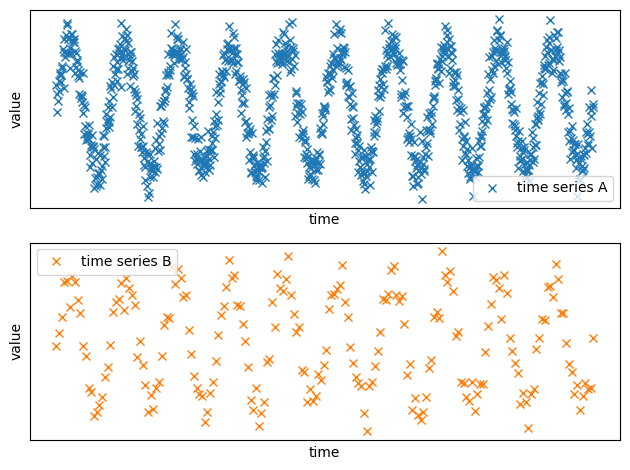

In [ ]:
def set_params_plot():
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("")


# Plot the data points
plt.subplot(2, 1, 1)
plt.plot(x_A, y_A, "x", label="time series A")
plt.legend()
set_params_plot()

plt.subplot(2, 1, 2)
plt.plot(x_B, y_B, "x", color="#ff7f0e", label="time series B")
plt.legend()
set_params_plot()

plt.tight_layout()
plt.show()

We can clearly see that the trend is the same, but the first source has clearly more data points.

Let's zoom on the first data points:

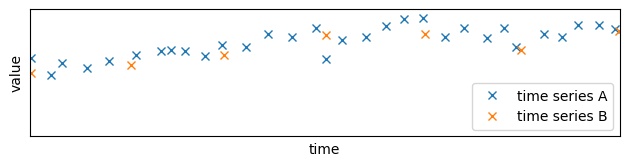

In [ ]:
def set_params_plot_zoom():
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlim([0, 300])
    plt.title("")


plt.subplot(3, 1, 1)
plt.plot(x_A, y_A, "x", label="time series A")
plt.plot(x_B, y_B, "x", color="#ff7f0e", label="time series B")
plt.legend(loc=4)
set_params_plot_zoom()

plt.tight_layout()
plt.show()

As we can see, not only the sampling rates are not the same, but the times are not aligned.

Let's load the data in Pathway before doing the upsampling:

In [ ]:
import pathway as pw

# To use advanced features with Pathway Scale, get your free license key from
# https://pathway.com/features and paste it below.
# To use Pathway Community, comment out the line below.
pw.set_license_key("demo-license-key-with-telemetry")

import pandas as pd


def load_to_pathway(x, y):
    time_series_pd = pd.DataFrame({"x": x, "y": y})
    return pw.debug.table_from_pandas(time_series_pd)


data_stream_A = load_to_pathway(x_A, y_A)
data_stream_B = load_to_pathway(x_B, y_B)

## Upsampling with `windowby`

While you could [combine the data streams](/developers/templates/combining_time_series) by keeping the union of the timestamps, this would mean altering two time series. Instead, upsampling alters only one data stream and thereby limits the imprecision introduced by the operation.

To do upsampling, you want to obtain an aggregation of the closest points of time series B for each point of the time series A, and then do an interpolation to obtain the value at the given time for time series B.

However, when dealing with streaming data, you do not have any assumption on the distribution of surrounding points.
You can ask for a fixed number of previous/next points, but you'd take the risk to obtain points with very different timestamps.
The solution is to ask for the data points in an interval around your point using a `windowby` with `intervals_over`.
If you need a quick reminder on how it works, don't hesitate to read the [tutorial about Gaussian filter](/developers/templates/gaussian_filtering_python#interval-joins-and-windowby).

Unlike applying a Gaussian filter, upsampling requires using two different tables.
You will do the `windowby` over the time series B (the one you want to upsample) and compute the intervals over the time series A (the one on which you want to align, with the higher sampling rate).
You must keep all the times and values within the intervals to be able to do the interpolation.

We set the length of the interval to 200 to be sure to have enough data points to do the interpolation:

In [ ]:
upsampled_stream = data_stream_B.windowby(
    data_stream_B.x,
    window=pw.temporal.intervals_over(
        at=data_stream_A.x, lower_bound=-100.0, upper_bound=100.0, is_outer=False
    ),
).reduce(
    x=pw.this._pw_window_location,
    xs=pw.reducers.ndarray(pw.this.x),
    ys=pw.reducers.ndarray(pw.this.y),
)

Now, let's define the interpolation as a UDF:

In [ ]:
@pw.udf
def linear_interpolate(times: np.ndarray, values: np.ndarray, time_new: int) -> float:
    idx = np.argsort(times)
    times = times[idx]
    values = values[idx]
    return np.interp(time_new, times, values, left=values[0], right=values[-1])

With this, you simply need to apply the interpolation to each window:

In [ ]:
upsampled_stream = upsampled_stream.select(
    pw.this.x, y=linear_interpolate(pw.this.xs, pw.this.ys, pw.this.x)
)

In [ ]:
upsampled_stream_pd = pw.debug.table_to_pandas(upsampled_stream)
upsampled_stream_pd = upsampled_stream_pd.sort_values(by=["x"])

Let's plot the resulting plots:

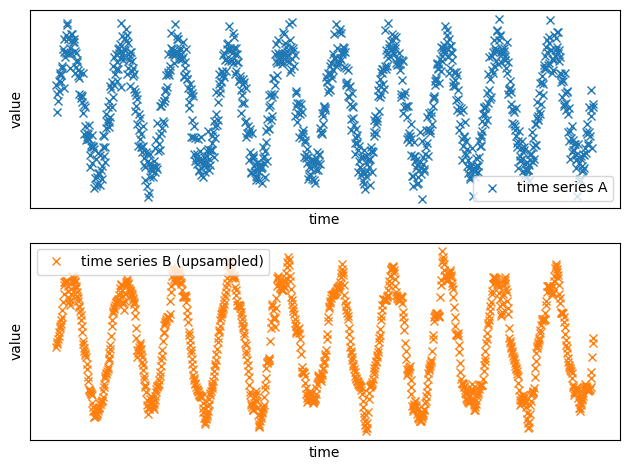

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x_A, y_A, "x", label="time series A")
plt.legend()
set_params_plot()

plt.subplot(2, 1, 2)
plt.plot(
    upsampled_stream_pd.x,
    upsampled_stream_pd.y,
    "x",
    color="#ff7f0e",
    label="time series B (upsampled)",
)
plt.legend()
set_params_plot()

plt.tight_layout()
plt.show()

Now the two time series have the same sampling rate!

Let's zoom in to see the difference more precisely:

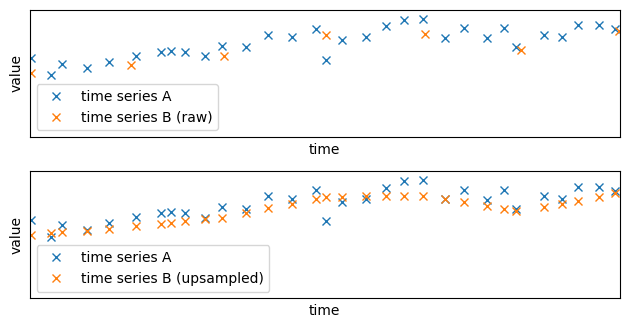

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(x_A, y_A, "x", label="time series A")
plt.plot(x_B, y_B, "x", color="#ff7f0e", label="time series B (raw)")
plt.legend()
set_params_plot_zoom()

plt.subplot(3, 1, 2)
plt.plot(x_A, y_A, "x", label="time series A")
plt.plot(
    upsampled_stream_pd.x,
    upsampled_stream_pd.y,
    "x",
    color="#ff7f0e",
    label="time series B (upsampled)",
)
plt.legend()
set_params_plot_zoom()

plt.tight_layout()
plt.show()

The new time series has been successfully upsampled: the values are sampled at the same times as the time series A.
Because the time series has been upsampled using interpolation, the obtained time series is smoother:

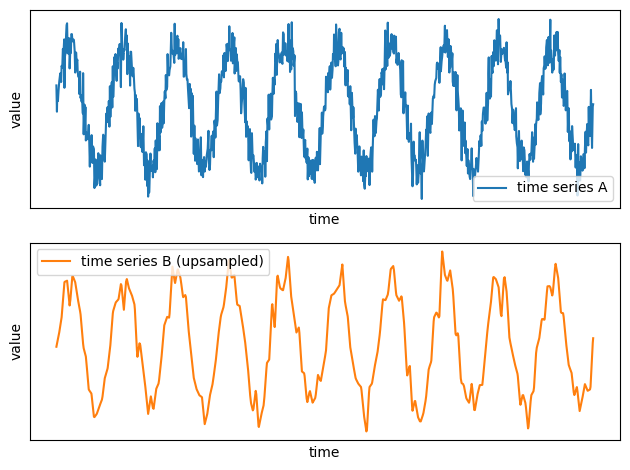

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x_A, y_A, label="time series A")
plt.legend()
set_params_plot()

plt.subplot(2, 1, 2)
plt.plot(
    upsampled_stream_pd.x,
    upsampled_stream_pd.y,
    color="#ff7f0e",
    label="time series B (upsampled)",
)
plt.legend()
set_params_plot()

plt.tight_layout()
plt.show()

You can now combine those two time series.
For example, you can compute the latitude by taking the average latitude at each time:

In [ ]:
average_stream = upsampled_stream.join(data_stream_A, pw.left.x == pw.right.x).select(
    pw.this.x, y=(pw.left.y + pw.right.y) / 2
)

In [ ]:
average_stream_pd = pw.debug.table_to_pandas(average_stream)
average_stream_pd = average_stream_pd.sort_values(by=["x"])

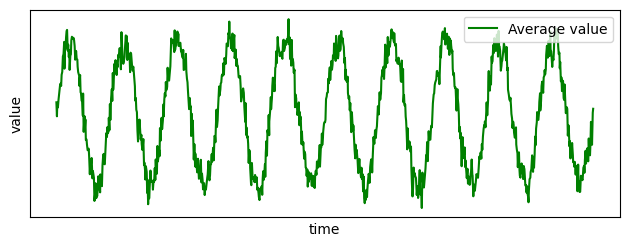

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(average_stream_pd.x, average_stream_pd.y, color="green", label="Average value")
plt.legend()
set_params_plot()

plt.tight_layout()
plt.show()

## Upsampling: Late and Out-of-Order Data Points

Standard digital signal processing systems assume robust sampling and would deal with out-of-order and irregularly sampled points by buffering and delaying the response.
This would be a problem for many real-world data applications in which irregular and out-of-order data is common place.
The system would stall as there is no way to push a late point through the pipeline.

This approach is impossible in a streaming setup where data points can be delayed indefinitely.
The best we can do is to do the computation with the information at hand and then update our results whenever late data is received.
This is exactly what Pathway does: your results are kept up-to-date with respect to the latest available data.
You can see how it works in practice with [our example about the Gaussian filter](/developers/templates/gaussian_filtering_python).

## Upsampling: Conclusion

You can now use Pathway to do signal processing on multiple data sources simultaneously, which is one of the common operations of DSP.
With multiple data sources and filters, you should be able to do most of the common digital signal processing operations with Pathway!

If you have trouble implementing a DSP operation, don't hesitate to join us on [discord](https://discord.com/invite/pathway) so we can help you!